# Lecture 3: Programming and Using a Matching Decoder
### James R. Wootton, IBM Quantum

## Making an error graph

In [1]:
from decodoku import Decodoku
from qiskit_qec.decoders import DecodingGraph
from retworkx.visualization import mpl_draw

In this lecture we are going to look at how to write a decoder. We'll start with one of the great workhorses of decoding algorithms: minimum weight perfect matching. This has quite broad applicability, but is especially well-suited to things like repetition codes, surface codes and the Decodoku puzzles we've seen so far.

So let's make something to decode.

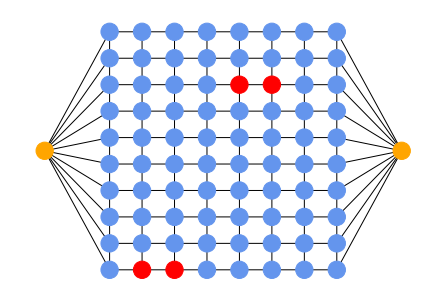

In [2]:
d = 9
p = 0.02

game = Decodoku(d=d, p=p)

game.draw_graph()

Our decoding is, of course, based around the decoding graph. So let's rename it something short and snappy: `dg`.

In [3]:
dg = game.decoding_graph.graph

Most of the decoding graph is actually blank space. The only parts that really interest us are the highlighted nodes. So let's create a new graph that contains only them. We'll call this the 'error graph'.

First, we'll just make a blank `DecodingGraph` object. We'll also give this the short and snappy name of `eg`.

In [4]:
error_graph = DecodingGraph(None)
eg = error_graph.graph

Next we go through all the nodes of `dg` and add only the highlighted ones to `eg`.

We'll also note down their positions. We could use these to help us calculate weights for edges, but here we'll actually just use them for plotting the error graph.

In [5]:
error_pos = []
for n, node in enumerate(dg.nodes()):
    if node['highlighted']:
        eg.add_node(node)
        error_pos.append(game.graph_pos[n])

Let's take a look at our error graph so far.

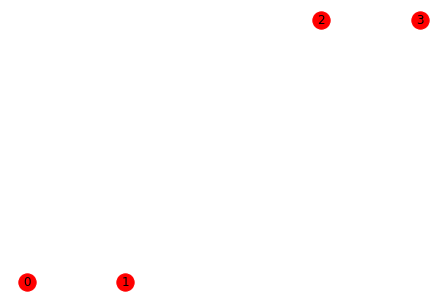

In [6]:
mpl_draw(eg, node_color='red', pos=error_pos, with_labels=True)

We have points but no edges. So what edges shall we add? And how to we account for the different distances?

For the latter point, we need to know what those distances are. We could determine these from the positions of the nodes, but this is not always so easy when we have more complex decoding graphs. Instead we can define the distance between two nodes as the number of edges requires to connect them. This makes sense from the perspective of decoding, since it corresponds to the number of errors required to create that pair of highlighted nodes.

Packages made to do graph theory usually have a way of figuring out these distances, and `retworkx` is no different. But we are going to do it manually using the coordinates. This is done in the following function.

In [7]:
def get_distance(graph, n0, n1):
    '''Takes two nodes of a decoding graph and returns the Manhattan distance'''

    node0 = graph[n0]
    node1 = graph[n1]
    
    # x distance
    dx = abs(node0['x']-node1['x'])
    
    # y distance (accounting for boundary)
    if node0['is_boundary'] or node1['is_boundary']:
        dy = 0
    else:
        dy = abs(node0['y']-node1['y'])
    
    return dx + dy

We don't actually need a fully connected graph. So to experiment with how to keep it simple, we can try putting an upper limit on the distance for which we assign an edge.

In [8]:
dist_max = 4

Now let's put in those edges.

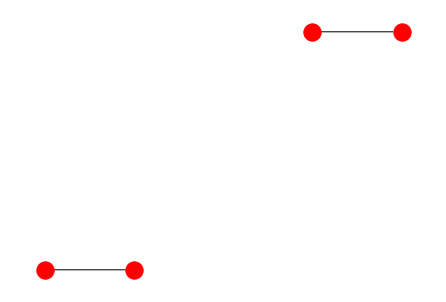

In [9]:
# these lines just repeat what we already did above, to save some effort if we want to rerun the process
error_graph = DecodingGraph(None)
eg = error_graph.graph
error_pos = []
for n, node in enumerate(dg.nodes()):
    if node['highlighted']:
        eg.add_node(node)  
        error_pos.append(game.graph_pos[n])

dg_nodes = dg.nodes()
# go through all pairs of nodes in eg
for n0, node0 in enumerate(eg.nodes()):
    for n1, node1 in enumerate(eg.nodes()):
        if n0<n1:
        
            # determine which nodes these are in dg
            dg_n0 = dg_nodes.index(node0)
            dg_n1 = dg_nodes.index(node1)
            # get the distance
            dist = get_distance(dg, dg_n0, dg_n1)
            # and add the edge
            if dist<=dist_max:
                error_graph.graph.add_edge(n0, n1, {'distance':dist})
        
mpl_draw(eg, node_color='red', pos=error_pos)

Now we've made a new graph out of just the highlighted nodes. Before we move on, let's note down how many nodes this has.

In [10]:
bulk_node_num = len(eg.nodes())

## Decoding with matching

### Why matching?

Let's think a bit more about what we know of decoding.

Errors create sets of highlighted nodes. Collective properties of these sets of errors also affect certain logical variables that we are interested in. The job of decoding is to figure out how these variables have been affected. Since this cannot be done with certainty, ideally we want to determine *the most likely way* they were affected.

There are often many possible sets of errors that could have caused any given set of higlighted nodes. We can categorize these according to the affect they have on the logical variables. All the sets of errors that cause the same logical effect are said to belong to the same equivalence class. Our job is therefore not to determine the most likely specific set of errors to have occurred, but to determine the most likely equivalence class.

This can be done, but it also can be difficult. Sometimes we need to make compromises. Rather than doing the best possible decoding, we'll do an approximation. And the most obvious approximation is to assume that the most likely equivalence class is the one with the most likely error.

Finding the most likely error is also a pretty complex optimization problem. Many graph-theoretic optimization problems are inefficient to solve. But there are some that do admit an efficient solution: minimum and maximum weight perfect matching.

Put simply, a **matching** is a pairing of the nodes of a graph. The nodes that are paired must be connected by an edge, and no node can be part of more than one pair.

A **perfect matching** is when the nodes become fully paired up, with every node part of a pair.

a **weighted matching** is where we assign a number as a weight to each edge. The total weight of the matching is then the sum of the weights for all the edges that correspond to the pairs.

The minimum and maximum weight matchings are then the matchings with the minimum and maximum total weight, given a particular graph. An algorithm to compute one can also compute the other, because we can simply multiply the weights by $-1$ to turn a minimum weight problem to a maximum weight problem.

This is the precisely the problem we need to solve in order to figure out the most likely set of errors in certain decoding problems. Specifically, those for which errors create pairs of highlighted edges.

Here we will consider the simple case that each error type occurs with equal probability. The most likely set of errors is therefore the one with the least errors. The weight we use is then simply the distance.

# Adding to the error graph

For codes like the Toric code, or repetition codes implemented on a loop, the periodic boundary conditions mean that *all* errors affect pairs of nodes. This means there are no weird boundaries to deal with. But in the case we are looking at now, a there is indeed a weird boundary. This means that isolated highlighted nodes can indeed exist, for which there is obviously no pairing possible. So how are we going to deal with this? The answer is to add more nodes.

For each node we add one additional 'virtual' twin. We associate this with the nearest boundary.

To begin, it'll be useful to know the index of the boundary nodes in `dg`. We'll use `dg_nr` for the right boundary and `dg_nl` for the left.

In [11]:
for n, node in enumerate(dg.nodes()):
    if node['x']==-1:
        dg_nl = n
    if node['x']==d-1:
        dg_nr = n

Now we will add in a virtual node for each bulk node.

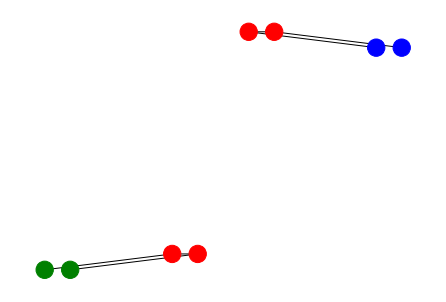

In [12]:
node_color = ['red']*len(eg.nodes())
virtuals = []

for n, node in enumerate(eg.nodes()):
    
    # copy each bulk node and flag up the copy as being on the boundary
    vnode = node.copy()
    vnode['is_boundary'] = True
    
    if node['x']<(d-1)/2:
        # if the node is on the left, also note this
        vnode['boundary'] = 'l'
        
        # determine the distance to the left boundary
        dg_n = dg_nodes.index(node)
        dist = get_distance(dg,dg_n, dg_nl)

        # and we place these on the left of any plot
        error_pos.append((node['x']-(d+1)/2,-node['y']-0.5))
        node_color.append('green')
    else:
        # similarly for the right
        vnode['boundary'] = 'r'
        dg_n = dg_nodes.index(node)
        dist = get_distance(dg,dg_n, dg_nr)
        error_pos.append((node['x']+(d+1)/2,-node['y']-0.5))
        node_color.append('blue')

    # add it to the graph
    nv = eg.add_node(vnode)
    
    # along with an edge, whose distance is of the straight line to the boundary
    eg.add_edge(n, nv, {'distance':dist})
    
    # it will be useful to keep track of which virtual nodes are where
    virtuals.append(nv)
        
mpl_draw(eg, node_color=node_color, pos=error_pos)

Now if a highlighted node is associated with the boundary, the matching can pair it with its virtual boundary counterpart.

But what about when the virtual nodes don't need to be used in this way? What will they pair with? To answer this, we connect them up with each other, using edges with weight zero.

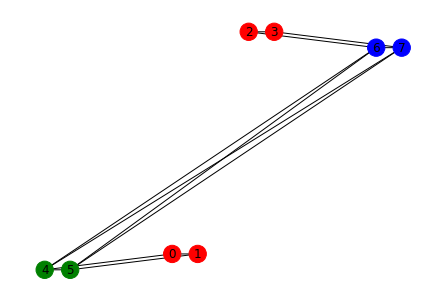

In [13]:
for nv0 in virtuals:
    for nv1 in virtuals:
        if nv0<nv1:
            eg.add_edge(nv0, nv1, {'distance':0})

mpl_draw(eg, node_color=node_color, pos=error_pos, with_labels=True)

Now finally we can find our favourite implementation of the algorithm that find minimum (or maximum) weight matchings and use it.

In [14]:
from retworkx import max_weight_matching

def weight_fn(edge):
    return -int(edge["distance"])

matching = max_weight_matching(eg, max_cardinality=True, weight_fn=weight_fn)

print(matching)

{(0, 1), (3, 2), (5, 6), (4, 7)}


Here is the chosen matching visualized.

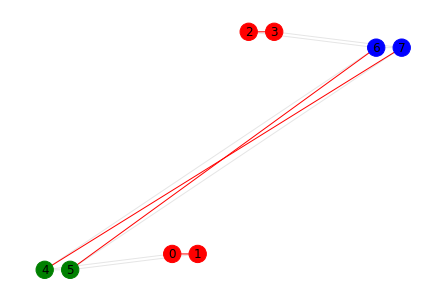

In [15]:
edge_color = []
for edge in eg.edge_list():
    
    if edge in matching or edge[::-1] in matching:
        edge_color.append('red')
    else:
        edge_color.append((0,0,0,0.1))

mpl_draw(eg, node_color=node_color, pos=error_pos, edge_color=edge_color, with_labels=True)

The decoders we write for Decodoku ask us to separate the nodes into clusters, which we think are connected by the same subset of errors. For the matching decoding, these are the pairs that correspond to the minimum weight matching.

We also need to find the boundary correction. This is the parity of the number of times that each boundary (i.e. the virtuals of each boundary) are connected to. This is done by the following (where we use `bc` rather than `boundary_corrections`.

In [16]:
bc = [0,0]
eg_nodes = eg.nodes()
for pair in matching:
    if pair[0]<bulk_node_num or pair[1]<bulk_node_num:
        for ne in pair:
            node = eg_nodes[ne]
            if node not in dg_nodes:
                if node['boundary']=='l':
                    bc[0] += 1
                else:
                    bc[1] += 1
bc = [bc[0]%2, bc[1]%2]
bc

[0, 0]

And there we have it. All that remains is to paste all the above into one big function to serve as our decoder.

In [17]:
def process(game):
    
    d = game.d
    dg = game.decoding_graph.graph
    
    error_graph = DecodingGraph(None)
    eg = error_graph.graph
    for n, node in enumerate(dg.nodes()):
        if node['highlighted']:
            eg.add_node(node)  

    dg_nodes = dg.nodes()
    # go through all pairs of nodes in eg
    for n0, node0 in enumerate(eg.nodes()):
        for n1, node1 in enumerate(eg.nodes()):
            if n0<n1:

                # determine which nodes these are in dg
                dg_n0 = dg_nodes.index(node0)
                dg_n1 = dg_nodes.index(node1)
                # get the distance
                dist = get_distance(dg, dg_n0, dg_n1)
                # and add the edge
                error_graph.graph.add_edge(n0, n1, {'distance':dist})

    # get number of bulk nodes
    bulk_node_num = len(eg.nodes())
    
    # get indices for boundary nodes
    for n, node in enumerate(dg.nodes()):
        if node['x']==-1:
            dg_nl = n
        if node['x']==d-1:
            dg_nr = n
    
    virtuals = []
    for n, node in enumerate(eg.nodes()):
        # copy each bulk node and flag up the copy as being on the boundary
        vnode = node.copy()
        vnode['is_boundary'] = True
        if node['x']<(d-1)/2:
            # if the node is on the left, also note this
            vnode['boundary'] = 'l'
            # determine the distance to the left boundary
            dg_n = dg_nodes.index(node)
            dist = get_distance(dg, dg_n, dg_nl)
            # and we place these on the left of any plot
            error_pos.append((node['x']-(d+1)/2,-node['y']-2))
            node_color.append('green')
        else:
            # similarly for the right
            vnode['boundary'] = 'r'
            dg_n = dg_nodes.index(node)
            dist = get_distance(dg,dg_n, dg_nr)
            error_pos.append((node['x']+(d+1)/2,-node['y']-2))
            node_color.append('blue')
        # add it to the graph
        nv = eg.add_node(vnode)
        # along with an edge, whose distance is of the straight line to the boundary
        eg.add_edge(n, nv, {'distance':dist})
        # it will be useful to keep track of which virtual nodes are where
        virtuals.append(nv)
    
    for nv0 in virtuals:
        for nv1 in virtuals:
            if nv0<nv1:
                eg.add_edge(nv0, nv1, {'distance':0})
        
    def weight_fn(edge):
        return -int(edge['distance'])

    matching = max_weight_matching(eg, max_cardinality=True, weight_fn=weight_fn) 
        
    bc = [0,0]
    clusters = {}
    c = 0
    eg_nodes = eg.nodes()
    for pair in matching:
        if pair[0]<bulk_node_num or pair[1]<bulk_node_num:
            for ne in pair:
                node = eg_nodes[ne]
                if node in dg_nodes:
                    nd = dg_nodes.index(eg_nodes[ne])
                    clusters[nd] = c
                else:
                    if node['boundary']=='l':
                        bc[0] += 1
                    else:
                        bc[1] += 1
            c += 1
    bc = [bc[0]%2, bc[1]%2]
    
    return bc, clusters

Now let's see how well it works

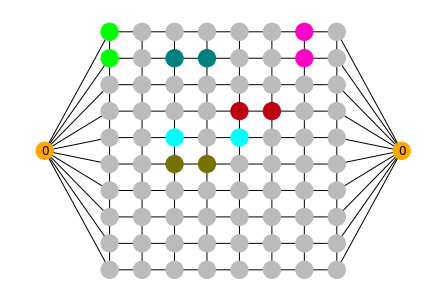

In [18]:
p = 0.05
game = Decodoku(d=d, p=p, process=process)

game.draw_graph()

In [19]:
game.run()

We can also try it on a few sets of errors we made earlier.

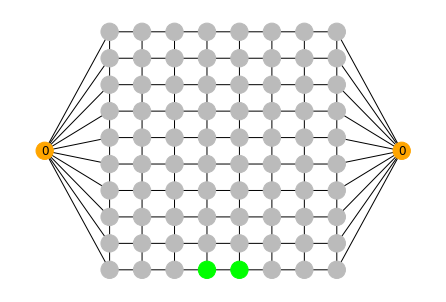

In [20]:
test_errors = [
    [(0,0,1,0), (d-1,0,d,0)],
    [((d-1)/2,d,(d-1)/2+1,d)],
    [(0,0,1,0), (d-1,0,d,0), ((d-1)/2,d,(d-1)/2+1,d)]   
]

game = Decodoku(d=d, process=process, errors=test_errors[1])

game.draw_graph()

Here's a more complex error, which we'll put on a slightly smaller graph.

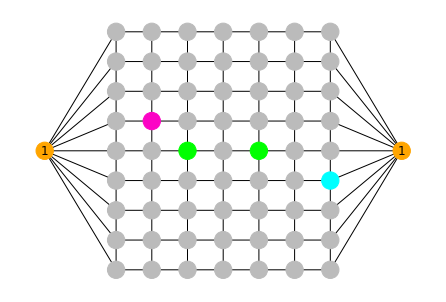

In [21]:
errors = [(2,3,3,4),(5,4,7,5)]

game = Decodoku(d=8, process=process, errors=errors)

game.draw_graph()

There are multiple sets of five errors that could have caused this. Two of these are shown in the image below. 

<img src="errors.png" alt="Drawing" style="width: 400px;"/>

Note that they belong to two different equivalence classes. The red set corresponds to the correct class (i.e. it corresponds to the `errors` list I used to set this puzzle up). But the decoder seems to have gone for the purple one.

This is not mistake by the decoder. According to the information it has, both equivalence classes are equal, so it just arbitrarily picks one. However, we could have coded it better. Let's use $n$ to denote the total number of edges, and $p$ to represent the probability of an error on any edge. The probability of any set of 5 errors is then $p^5 (1-p)^{n-5}$.

If we restrict to just these minimal error sets, the probability of the single set of errors that puts us in the purple class is

$P_{\rm purple} = p^5 (1-p)^{n-5}.$

But note that there are multiple equal length paths that could take the place of the ones highlighted in red: two for the pair of nodes on the left and four for the right. So

$P_{\rm red} = 6 \times p^5 (1-p)^{n-5}.$

This shows us that the red equivalence class is actually more likely. So how could we have told our decoder about this?

First let's rewrite things in a way that makes more sense for the edges of the error graph. Specifically, we want to see which terms correspond to the different pairs of nodes. In the red case, we can think of there being two independent sets of errors: one with 2 errors and 2 possibilities, the other with 3 errors and 3 possibilities. So

$P_{\rm purple} = \left( \frac{p}{1-p} \right)^2 \times \left( \frac{p}{1-p} \right)^2 \times \left( \frac{p}{1-p} \right)^1 \times (1-p)^n.$

$P_{\rm red} = 2 \times \left( \frac{p}{1-p} \right)^2 \times 3 \times \left( \frac{p}{1-p} \right)^3 \times (1-p)^n.$

Note that the factor of $(1-p)^n$ is common to both. It contains no information about any possible set of errors. When comparing probabilities, we can therefore just ignore it.

Next we will make it so that the contributions from each pair of nodes add together rather than multiply together. This is done by taking the logarithm of each side. To make things simpler, we'll replace the constantly occuring $p/(1-p)$ with

$w = -\log{\frac{p}{1-p}}.$

The minus sign is used here such that we can thing of $w$ as a positive valued 'weight'. The logarithms are then

$\log{P_{\rm purple}} = 2 w \, + \, 2 w \, + \, 1 w \,\, + \,\, {\rm const},$

$\log{P_{\rm red}} = \left(\log{2} + 2 w \right) + \left(\log{4} + 3 w \right) \,\, + \,\,  {\rm const}.$

From this we can extract better choices for the distances in the error graph. Rather than just a simple distance, we could use a sum of edge weights that depend on probabilities, with an additional entropic correction. The comparision of matching weights then corresponds exactly to a comparison of total error probabilities.

If we did this, the entropic corrections would ensure that the decoder opts for the red outcome instead, as it should. So let's update the distance function.

In [22]:
import math

def get_distance(graph, n0, n1):
    
    node0 = graph[n0]
    node1 = graph[n1]
    
    # x distance
    dx = abs(node0['x']-node1['x'])
    
    # y distance (accounting for boundary)
    if node0['is_boundary'] or node1['is_boundary']:
        dy = 0
    else:
        dy = abs(node0['y']-node1['y'])   
    
    # number of minimum distance paths
    # this is dx+dy choose dx
    num = math.comb(dx+dy, dx)
    
    # the final weight combines these (and needs to be an integer, and so needs a scaling factor)
    weight = int(100*(- math.log( p/(1-p) )*(dx+dy) - math.log(num)))
        
    return weight

Let's see what the matching does now.

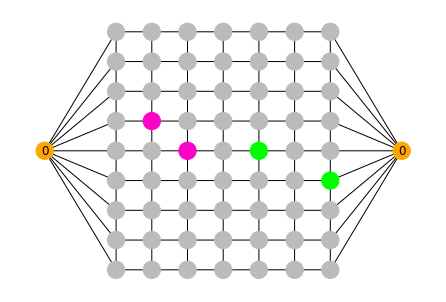

In [23]:
game = Decodoku(d=8, process=process, errors=errors)

game.draw_graph()

Now it has chosen the most entropically likely error.

Let's see what the threshold plot looks like!

In [24]:
from matplotlib import pyplot as plt

def get_logical_probs(ds,ps,process):
    logical_probs = {}
    for d in ds:
        logical_probs[d] = []
        for p in ps:
            error_num = 0
            sample_num = 0
            game = Decodoku(d=d, p=p, process=process)
            for _ in range(10**3):
                bc, clusters = game.process(game)
                error_num += bc!=game.boundary_errors
                sample_num += 1
                game.restart()
            logical_probs[d].append(error_num/sample_num)
    return logical_probs

def threshold_plot(logical_probs):
    plt.figure(figsize=(10,7))
    for d in ds:
        plt.scatter(ps,logical_probs[d],label='d='+str(d))
    plt.xlabel('p')
    plt.ylabel('logical prob')
    plt.legend()

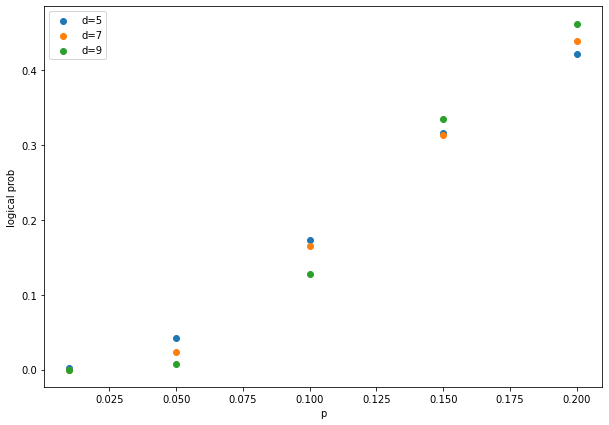

In [25]:
ds = [5, 7, 9]
ps = [0.01, 0.05, 0.1, 0.15, 0.2]

logical_probs = get_logical_probs(ds,ps,process)

threshold_plot(logical_probs)

As a quickly run set of points for relatively small codes, it is hardly the best threshold plot ever made. Nevertheless, we can see that bigger codes allow for better correction below a threshold of around $p=0.11$. Which is exactly what we expect from the classic paper of [Dennis, Landahl, Kitaev and Preskill](https://arxiv.org/abs/quant-ph/0110143).

## Getting weights from real data

So far we've looked at cases where every type of error occurs with equal probability $p$. But this won't be the case in real life. Instead, there will be a unique $p_j$ for each and every edge in the decoding graph. And hence a unique edge weight $w_j$.

Let's see this by taking a look at real life! We are going to run some QEC $^*$ on a quantum computer $^\dagger$!

$^*$ If you count repetition codes as QEC

$^\dagger$ not a very big one

In [26]:
# import stuff
from qiskit import IBMQ
import qiskit.tools.jupyter

# load you account credential stuff
IBMQ.load_account()

# pick one of your providers
provider = IBMQ.providers()[0]

Set up the backend object for the device you want to use. Here's the one for a publically available 7 qubit device.

In [27]:
backend = provider.get_backend('ibm_nairobi')

backend

<IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>

Now we are going to set up some repetition code circuits.

In [28]:
from qiskit_qec.circuits import RepetitionCodeCircuit
from qiskit_qec.decoders import DecodingGraph

We have enough qubits for a `d=3` code (requiring a line of five qubits). We'll do one for the phase flip encoding this time. And since measurement and reset are long gates, we'll skip the resets.

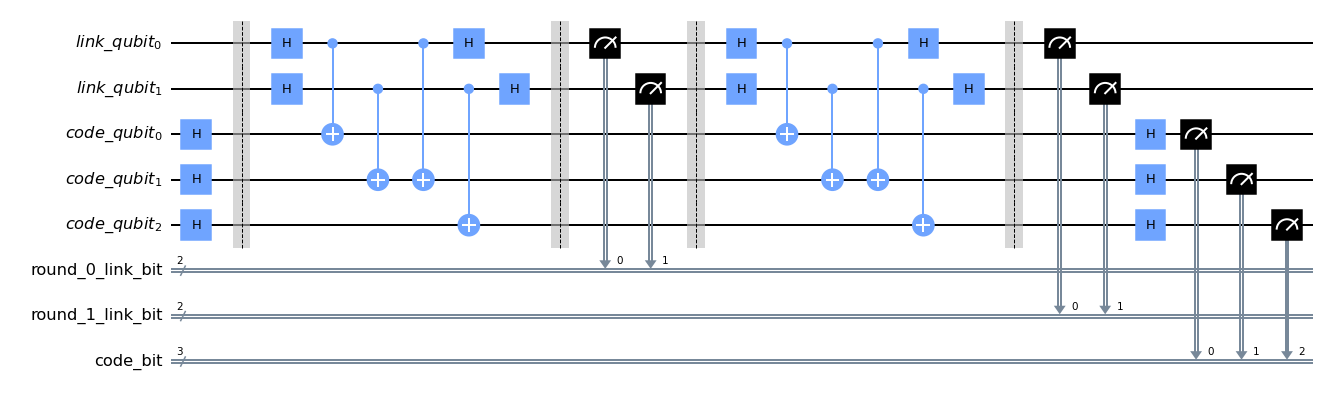

In [29]:
d = 3
T = 2
code = RepetitionCodeCircuit(d, T, xbasis=True, resets=False, barriers=True)

code.circuit['0'].draw(output='mpl')

When running the circuit on the device, we'll want to choose which qubits play which roles. Let's go for the line `0-1-3-5-6`. That means the code qubits are `0`, `3` and `6`, and the link qubits are `1` and `5`.

In [30]:
code_qubits = [0,3,6]
link_qubits = [1,5]

This information can provided to the transpiler to guide it when rewriting the circuit for the backend. 

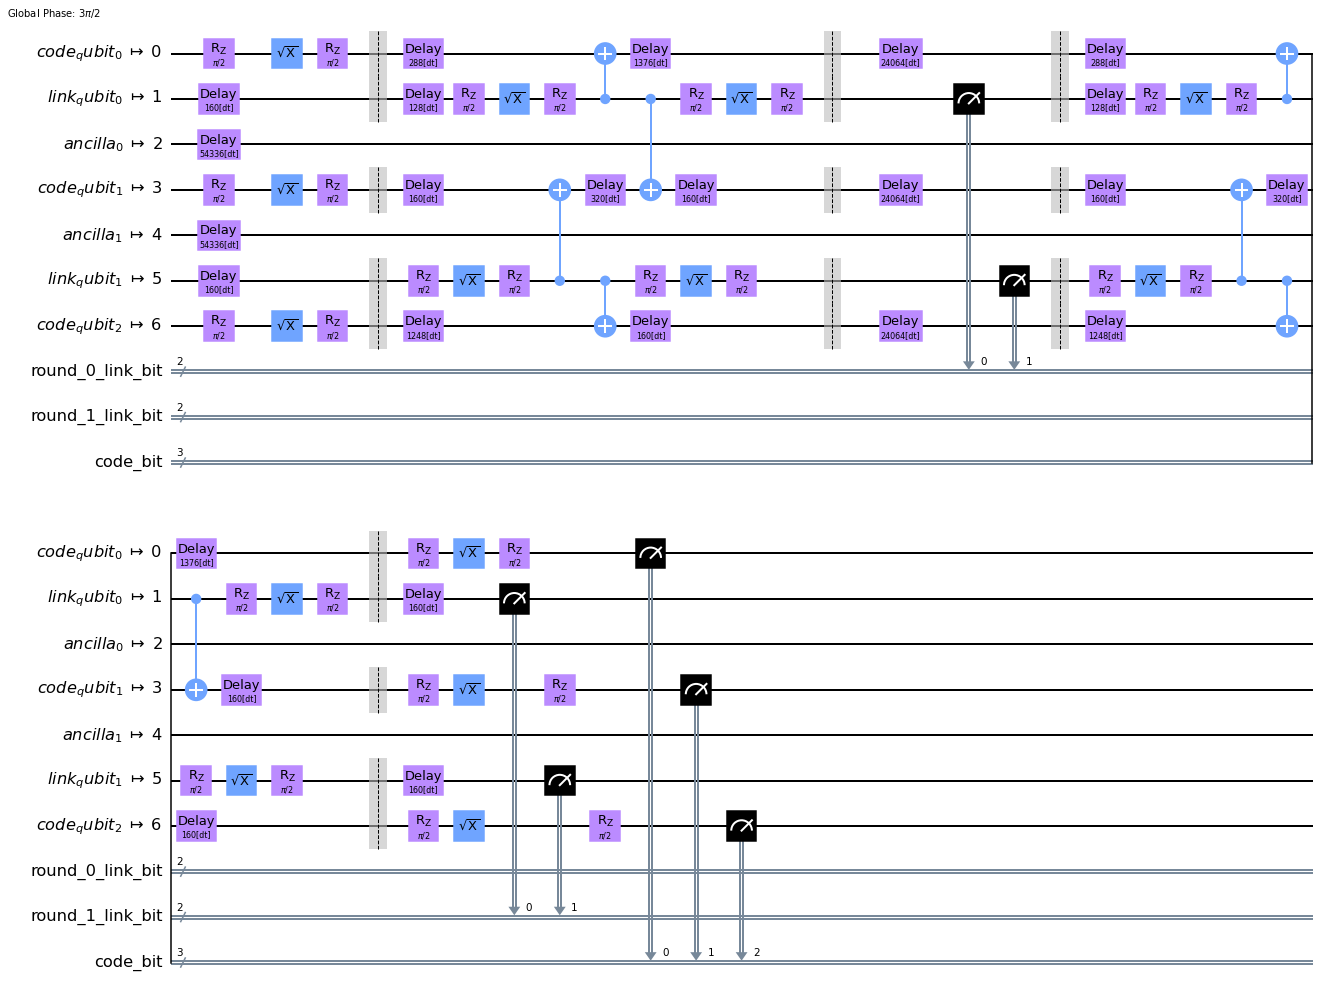

In [31]:
from qiskit import transpile

qc = transpile(code.circuit['0'], backend, initial_layout=link_qubits+code_qubits, scheduling_method='alap')

qc.draw(output='mpl')

We also used the transpiler to schedule the circuit. So we can now also see a scheduled version of the circuit.

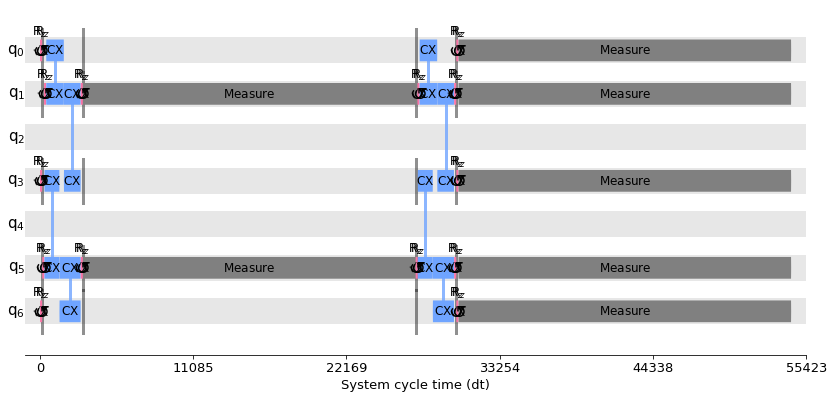

In [32]:
from qiskit.visualization.timeline import draw

draw(qc)

QEC is a powerful tool, but it's also good to fix errors before they get to QEC. We can do this by adding in dynamical decoupling.

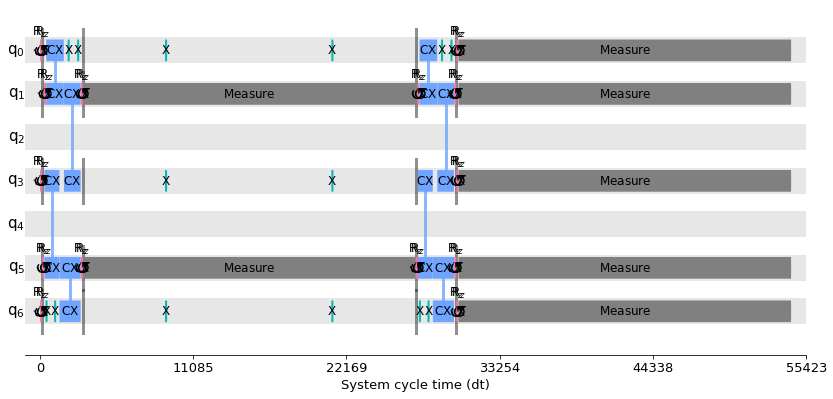

In [33]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import DynamicalDecoupling

dd_sequence = [XGate()]*2
durations = InstructionDurations().from_backend(backend)

pm = PassManager([DynamicalDecoupling(durations, dd_sequence, qubits=code_qubits)])
qc = pm.run(qc)

draw(qc)

Uncomment the following to run the circuit and get the results.

In [34]:
#job = backend.run(qc)
#counts = job.result().get_counts()

Otherwise, here are some results I made earlier, with a code centered around qubit `2` of the 27 qubit `ibm_cairo`.

In [35]:
counts = {'000 00 00': 61253, '000 00 01': 430, '001 00 00': 10781, '001 00 01': 1634, '001 00 10': 23, '001 00 11': 6, '001 01 00': 8598, '001 01 01': 1362, '001 01 10': 14, '001 01 11': 1, '001 10 00': 117, '001 10 01': 17, '001 10 10': 200, '001 10 11': 31, '001 11 00': 103, '001 11 01': 22, '001 11 10': 145, '001 11 11': 26, '000 00 10': 140, '010 00 00': 389, '010 00 01': 89, '010 00 10': 37, '010 00 11': 836, '010 01 00': 203, '010 01 01': 59, '010 01 10': 99, '010 01 11': 79, '010 10 00': 115, '010 10 01': 221, '010 10 10': 28, '010 10 11': 75, '010 11 00': 596, '010 11 01': 64, '010 11 10': 50, '010 11 11': 28, '000 00 11': 4, '011 00 00': 95, '011 00 01': 24, '011 00 10': 54, '011 00 11': 101, '011 01 00': 102, '011 01 01': 29, '011 01 10': 46, '011 01 11': 113, '011 10 00': 135, '011 10 01': 48, '011 10 10': 13, '011 10 11': 6, '011 11 00': 163, '011 11 01': 55, '011 11 10': 23, '011 11 11': 19, '000 01 00': 2581, '100 00 00': 726, '100 00 01': 1, '100 00 10': 903, '100 00 11': 9, '100 01 00': 35, '100 01 01': 22, '100 01 10': 40, '100 01 11': 31, '100 10 00': 1088, '100 10 01': 10, '100 10 10': 209, '100 10 11': 5, '100 11 00': 34, '100 11 01': 31, '100 11 10': 9, '100 11 11': 12, '000 01 01': 2100, '101 00 00': 142, '101 00 01': 16, '101 00 10': 165, '101 00 11': 26, '101 01 00': 111, '101 01 01': 16, '101 01 10': 148, '101 01 11': 18, '101 10 00': 202, '101 10 01': 14, '101 10 10': 43, '101 10 11': 7, '101 11 00': 203, '101 11 01': 23, '101 11 10': 39, '101 11 11': 6, '000 01 10': 5, '110 00 00': 12, '110 00 01': 18, '110 00 10': 4, '110 00 11': 20, '110 01 00': 10, '110 01 01': 4, '110 01 10': 7, '110 01 11': 3, '110 10 00': 8, '110 10 01': 4, '110 10 10': 4, '110 10 11': 20, '110 11 00': 7, '110 11 01': 1, '110 11 10': 12, '110 11 11': 2, '000 01 11': 9, '111 00 00': 2, '111 00 01': 1, '111 00 10': 3, '111 00 11': 2, '111 01 00': 6, '111 01 01': 8, '111 01 10': 2, '111 01 11': 1, '111 10 00': 2, '111 10 01': 3, '111 10 10': 1, '111 10 11': 4, '111 11 00': 3, '111 11 10': 3, '111 11 11': 1, '000 10 00': 607, '000 10 01': 13, '000 10 10': 1118, '000 10 11': 14, '000 11 00': 30, '000 11 01': 18, '000 11 10': 41, '000 11 11': 41}


Qiskit-QEC is able to analyze the syndrome information here to determine all the probabilities, $p_j$, for each edge. We use the algorithm of [Spitz, Tarasinski, Beenakker and O'Brien](https://doi.org/10.1002/qute.201800012). See [my recent paper](https://arxiv.org/abs/2207.00553) for more information.

Basically, once you have the decoding graph

In [36]:
decoding_graph = DecodingGraph(code)

you supply the `counts` dictionary to the `get_error_probs` method.

In [37]:
error_probs = decoding_graph.get_error_probs(counts)
error_probs

{(2, 1): 0.01452807199831746,
 (1, 4): 0.04474023541581679,
 (2, 5): 0.02272371293159753,
 (1, 5): 0.004692792184319616,
 (5, 4): 0.01217521805596311,
 (4, 6): 0.03630048668804137,
 (5, 7): 0.015218668667994983,
 (4, 7): 0.005147947750077431,
 (7, 6): 0.0078121435203278855,
 (1, 1): 0.019426362602676328,
 (2, 2): 0.016452524339903296,
 (4, 4): 0.10351778547680235,
 (5, 5): 0.010244646193699636,
 (6, 6): 0.14708424118753444,
 (7, 7): 0.011215156667605308}

With these we can make weights that are very much tailored to the hardware on which our code is being run.